# Import Libraries

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
import cv2
import random
import datetime
import neptune
import tempfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow.keras.backend as K

from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as prep_input_mobilenetv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

if '../../../notebooks/' not in sys.path:
    sys.path.append('../../../notebooks/')

import utils.constants as cts
import utils.draw_utils as dr

from models.oface_mouth_model import OpenfaceMouth

from data_loaders.data_loader import DLName

from net_data_loaders.net_data_loader import NetDataLoader

from gt_loaders.gen_gt import Eval
from gt_loaders.fvc_gt import FVC_GTLoader
from gt_loaders.pybossa_gt import PybossaGTLoader

# Load the TensorBoard notebook extension
# %load_ext tensorboard

## Restrict GPU Memory Growth

In [5]:
## restrict memory growth -------------------

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
    raise Exception("Invalid device or cannot modify virtual devices once initialized.")

## restrict memory growth -------------------

# Start Experiment Manager

In [6]:
def lr_scheduler(epoch):
#     if epoch < 10:
#         new_lr = PARAMS['learning_rate']
#     else:
    new_lr = PARAMS['learning_rate'] * np.exp(0.1 * ((epoch//50)*50 - epoch))

    #neptune.log_metric('learning_rate', new_lr)
    return new_lr

# Load Data

In [7]:
m = OpenfaceMouth()
req = cts.ICAO_REQ.MOUTH
dl_names = [DLName.FVC_PYBOSSA]
print(f'DL names: {dl_names}')

print('Loading data')
netDataLoader = NetDataLoader(m, req, dl_names, True)
in_data = netDataLoader.load_data()
# in_data = pd.read_csv(cts.LABELS_FQA_SCORES_DATA_PATH)
# in_data = in_data[in_data.fqa_score >= 0.5]
# in_data = in_data.astype({'comp':'str'})
print('Data loaded')

DL names: [<DLName.FVC_PYBOSSA: 'fvc_pybossa'>]
Loading data
Input data.shape: (5780, 4)
Data loaded


In [8]:
in_data.head()

,origin,img_name,comp,aligned
0,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,1,True
1,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0,True
2,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0,True
3,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0,True
4,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,1,True


In [9]:
print(in_data[in_data.comp == Eval.COMPLIANT.value].shape[0], in_data[in_data.comp == Eval.NON_COMPLIANT.value].shape[0])

4568 1212


In [10]:
final_df = pd.DataFrame()

df_comp = in_data[in_data.comp == Eval.COMPLIANT.value]
df_non_comp = in_data[in_data.comp == Eval.NON_COMPLIANT.value]

print(df_comp.shape, df_non_comp.shape)

n_imgs = df_non_comp.shape[0]
print(n_imgs)

df_comp = df_comp[:n_imgs].copy()

final_df = final_df.append(df_comp)
final_df = final_df.append(df_non_comp)

print(final_df.shape)
print(final_df[final_df.comp == Eval.COMPLIANT.value].shape[0])
print(final_df[final_df.comp == Eval.NON_COMPLIANT.value].shape[0])

(4568, 4) (1212, 4)
1212
(2424, 4)
1212
1212


# Data Generators

In [ ]:
kwargs = { 
    'exp_params' : {
        'name': 'train_mobilenetv2',
        'description': 'Changing network architecture and BS',
        'tags': ['mobilenetv2'],
        'src_files': ['mobilenet_trainer.py','net_trainer.py']
    },
    'properties': {
        'tagger_model': OpenfaceMouth(),
        'dl_names': [DLName.FVC_PYBOSSA],
        'req': cts.ICAO_REQ.MOUTH,
        'aligned': True 
    },
    'net_train_params': {
        'batch_size': 64,
        'n_epochs': 30,
        'early_stopping': 10,
        'shuffle': False,
        'dense_units': 128,
        'learning_rate': 1e-4,
        'optimizer': 'Adam',
        'dropout': 0.5,
        'train_prop': 0.8,
        'validation_prop': 0.1,
        'test_prop': 0.1,
        'seed': 42,
        'validation_split': 0.1
    }
}

trainer = NetworkTrainer(use_neptune=False, **kwargs)

In [11]:
TRAIN_PROP = 0.8
VALID_PROP = 0.1
TEST_PROP = 0.1
SEED = 42

print(f'N: {len(in_data)}')

INIT_LR = 1e-4
EPOCHS = 30
BS = 64
SHUFFLE = True
DROPOUT = 0.5
EARLY_STOPPING = 10
OPTIMIZER = 'Adam'
DENSE_UNITS = 128

print('Starting data generators')
train_valid_df = final_df.sample(frac=TRAIN_PROP+VALID_PROP, random_state=SEED)
test_df = final_df[~final_df.img_name.isin(train_valid_df.img_name)]
# train_valid_df = in_data.sample(frac=TRAIN_PROP+VALID_PROP, random_state=SEED)
# test_df = in_data[~in_data.img_name.isin(train_valid_df.img_name)]

print('Starting data generators')
datagen = ImageDataGenerator(preprocessing_function=prep_input_mobilenetv2, 
                             validation_split=0.2)


train_gen = datagen.flow_from_dataframe(train_valid_df, 
                                        x_col="img_name", 
                                        y_col="comp",
                                        target_size=(224, 224),
                                        class_mode="raw",
                                        batch_size=BS, 
                                        subset='training',
                                        shuffle=False,
                                        seed=SEED)

validation_gen = datagen.flow_from_dataframe(train_valid_df,
                                            x_col="img_name", 
                                            y_col="comp",
                                            target_size=(224, 224),
                                            class_mode="raw",
                                            batch_size=BS, 
                                            subset='validation',
                                            shuffle=False,
                                            seed=SEED)

test_gen = datagen.flow_from_dataframe(test_df,
                                       x_col="img_name", 
                                       y_col="comp",
                                       target_size=(224, 224),
                                       class_mode="raw",
                                       batch_size=BS,
                                       shuffle=False,
                                       seed=SEED)

print(f'TOTAL: {train_gen.n + validation_gen.n + test_gen.n}')

N: 5780
Starting data generators
Starting data generators
Found 1746 validated image filenames.
Found 436 validated image filenames.
Found 242 validated image filenames.
TOTAL: 2424


# Create Experiment

In [12]:
# Define parameters
PARAMS = {'batch_size': BS,
          'n_epochs': EPOCHS,
          'shuffle': SHUFFLE,
          'dense_units': DENSE_UNITS,
          'learning_rate': INIT_LR,
          'optimizer': OPTIMIZER,
          'dropout': DROPOUT,
          'early_stopping': EARLY_STOPPING,
          'train_prop': TRAIN_PROP,
          'validation_prop': VALID_PROP,
          'test_prop': TEST_PROP,
          'n_train': train_gen.n,
          'n_validation': validation_gen.n,
          'n_test': test_gen.n,
          'seed': SEED}

# Training Model

In [13]:
class MyCallback(tf.keras.callbacks.Callback): 
    def __init__(self, val_gen):
        self.val_gen = val_gen
        self.out_file_path = 'output/out.csv'
    
    def __clean_out_file(self):
        if os.path.exists(self.out_file_path):
            os.remove(self.out_file_path)
    
    def on_epoch_end(self, epoch, logs={}): 
        if epoch == 0:
            self.__clean_out_file()

#         print(f'Validation Accuracy: {self.model.evaluate(self.val_gen, batch_size=BS)}')
        
        with open(self.out_file_path,'a') as f:
            predIxs = self.model.predict(self.val_gen, batch_size=BS)
            Y = self.val_gen.labels
            Y_hat = np.argmax(predIxs, axis=1)
            for idx,(y,y_h) in enumerate(zip(Y,Y_hat)):
                if epoch == 0 and idx == 0:
                    f.writelines('epoch,idx,y,y_hat\n')
                f.writelines(f'{epoch+1},{idx},{y},{y_h}\n')    

In [14]:
print('Training network')

# log_dir = "tensorboard_out/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint_filepath = '/output/checkpoint_epoch_{}'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_freq='epoch')

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3),
	input_tensor=Input(shape=(224,224,3)))

for layer in baseModel.layers:
	layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(PARAMS['dense_units'], activation="relu")(headModel)
headModel = Dropout(PARAMS['dropout'])(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Log model summary
# model.summary(print_fn=lambda x: neptune.log_text('model_summary', x))

# train the head of the network
H = model.fit(
        train_gen,
        steps_per_epoch=train_gen.n // BS,
        validation_data=validation_gen,
        validation_steps=validation_gen.n // BS,
        epochs=EPOCHS,
        callbacks=[
#             LambdaCallback(on_epoch_end = lambda epoch, logs: log_data(logs)),
            EarlyStopping(patience=PARAMS['early_stopping'], monitor='accuracy', restore_best_weights=True),
            LearningRateScheduler(lr_scheduler),
#             MyCallback(validation_gen)
#               tensorboard_callback
        ])

Training network
Epoch 1/30
27/27 [==============================] - 17s 624ms/step - loss: 0.8599 - accuracy: 0.4816 - val_loss: 0.7227 - val_accuracy: 0.4479
Epoch 2/30
27/27 [==============================] - 4s 142ms/step - loss: 0.7589 - accuracy: 0.4899 - val_loss: 0.7064 - val_accuracy: 0.5130
Epoch 3/30
27/27 [==============================] - 4s 144ms/step - loss: 0.7256 - accuracy: 0.5089 - val_loss: 0.7006 - val_accuracy: 0.5208
Epoch 4/30
27/27 [==============================] - 4s 140ms/step - loss: 0.7107 - accuracy: 0.4988 - val_loss: 0.6979 - val_accuracy: 0.5104
Epoch 5/30
27/27 [==============================] - 4s 143ms/step - loss: 0.7047 - accuracy: 0.4893 - val_loss: 0.6967 - val_accuracy: 0.5156
Epoch 6/30
27/27 [==============================] - 4s 137ms/step - loss: 0.7017 - accuracy: 0.5006 - val_loss: 0.6959 - val_accuracy: 0.5234
Epoch 7/30
27/27 [==============================] - 4s 140ms/step - loss: 0.6993 - accuracy: 0.4810 - val_loss: 0.6955 - val_accur

# Plots

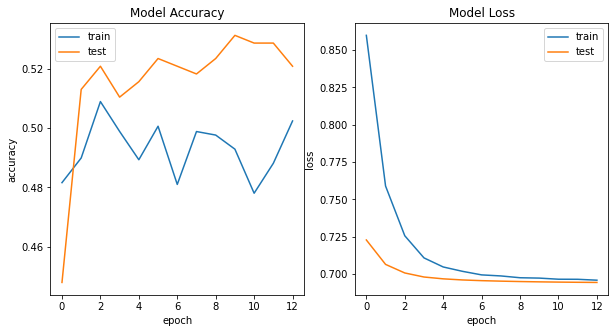

In [40]:
f,ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(H.history['accuracy'])
ax[0].plot(H.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'])

ax[1].plot(H.history['loss'])
ax[1].plot(H.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'])

plt.show()

# Saving Trained Model

# Test Trained Model

In [17]:
print("Testing Trained Model")

predIdxs = model.predict(test_gen, batch_size=BS)
y_hat = np.argmax(predIdxs, axis=1)

print(classification_report(test_gen.labels, y_hat, target_names=['NON_COMP','COMP']))

print(f'Model Accuracy: {round(accuracy_score(test_gen.labels, y_hat), 4)}')

Testing Trained Model
              precision    recall  f1-score   support

    NON_COMP       0.54      0.54      0.54       137
        COMP       0.41      0.41      0.41       105

    accuracy                           0.48       242
   macro avg       0.47      0.47      0.47       242
weighted avg       0.48      0.48      0.48       242

Model Accuracy: 0.4835


# Evaluate Model

In [18]:
print('Evaluating model')
eval_metrics = model.evaluate(test_gen, batch_size=BS, verbose=0)

print(f'Loss: {round(eval_metrics[0], 4)}')
print(f'Accuracy: {round(eval_metrics[1], 4)}')

Evaluating model
Loss: 0.7009
Accuracy: 0.4835


# Vizualize Model Classification

## GradCam Application

Based on [link 1](https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras) and [link 2](https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48).

In [29]:
def calc_heatmap(img_name, width, height):
    image = load_img(img_name, target_size=(width, height))
    img_tensor = img_to_array(image)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = prep_input_mobilenetv2(img_tensor)

    last_conv_layer_name = [l.name for l in model.layers if isinstance(l, tf.python.keras.layers.convolutional.Conv2D)][-1]

    conv_layer = model.get_layer(last_conv_layer_name)
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    # Get gradient of the winner class w.r.t. the output of the (last) conv. layer
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Channel-wise mean of resulting feature-map is the heatmap of class activation
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    # Render heatmap via pyplot
    # plt.imshow(heatmap[0])
    # plt.show()

    upsample = cv2.resize(heatmap[0], (width,height))
    return upsample

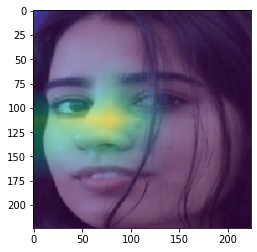

In [30]:
tmp_df = test_df.sample(n = 50, random_state=42)

im = tmp_df.img_name.values[3]
w,h = 224,224
heatmap = calc_heatmap(im, w, h)

plt.imshow(load_img(im, target_size=(w,h)))
plt.imshow(heatmap, alpha=0.5)
plt.show()

## Run Model on Test Data

In [31]:
preds = np.argmax(model.predict(test_gen), axis=1)
for idx,_ in test_df.iterrows():
    test_df.loc[idx, 'pred'] = preds[idx]

round(accuracy_score(y_true=test_df.comp.values, y_pred=test_df.pred.values),4)

0.4835

## Vizualize Predictions and Heatmaps

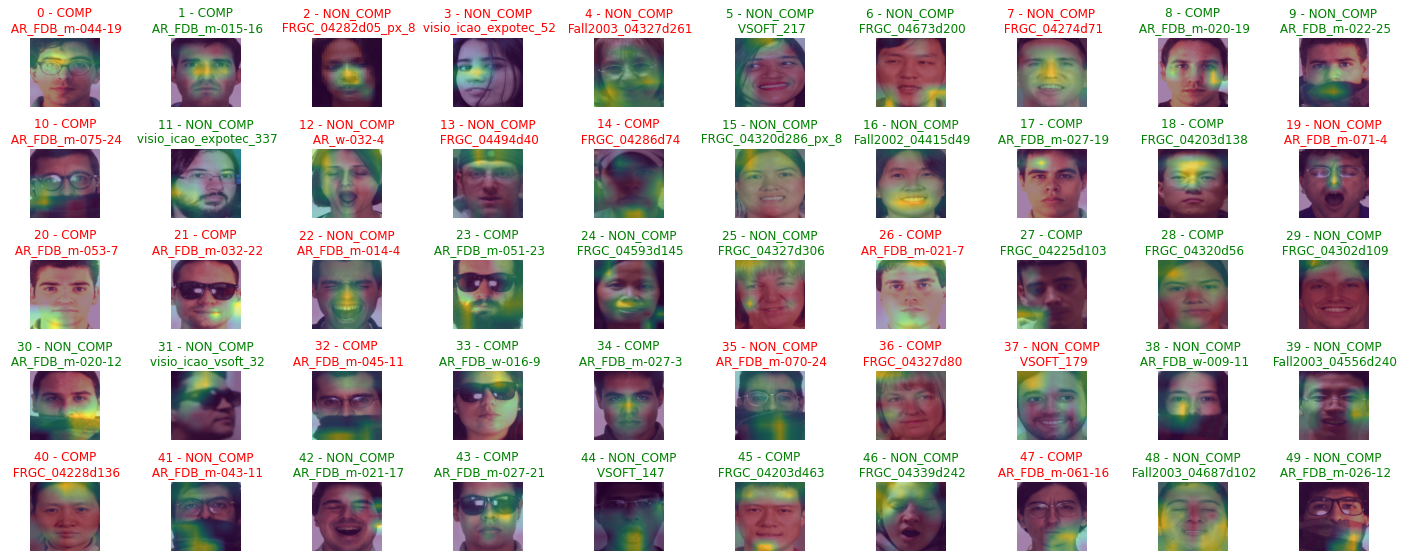

In [46]:
tmp_df = test_df.sample(n = 50, random_state=42)

def get_img_name(img_path):
    return img_path.split("/")[-1].split(".")[0]

labels = [f'COMP\n {get_img_name(path)}' if x == Eval.COMPLIANT.value else f'NON_COMP\n {get_img_name(path)}' for x,path in zip(tmp_df.comp.values, tmp_df.img_name.values)]
preds = [f'COMP\n {get_img_name(path)}' if x == Eval.COMPLIANT.value else f'NON_COMP\n {get_img_name(path)}' for x,path in zip(tmp_df.pred.values, tmp_df.img_name.values)]
heatmaps = [calc_heatmap(im_name, 224,224) for im_name in tmp_df.img_name.values]

out = dr.draw_imgs([cv2.imread(img) for img in tmp_df.img_name.values], labels=labels, predictions=preds, heatmaps=heatmaps)

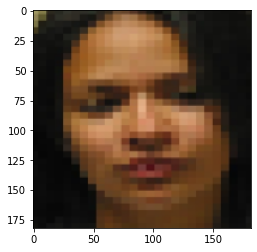

In [28]:
dr.draw_img(cv2.imread(tmp_df.img_name.values[2]))

# Finishing Experiment Manager